## Credit
This notebook is based on a notebook by Frederik Hvilshøj [[4]](#References), which was created as part of a talk he held Wednesday, December 19th 2018, in the ML Journal Club at the Engineering Department at Aarhus University. It is inspired the paper by Kingma and Welling [[1]](#References) and the tutorial by Doersch [[2]](#References).


---




# Variational Auto-encoders


## Agenda
1. Introduction
2. Auto-encoders
3. Variational Auto-encoders

## Introduction

Deep neural networks is a class of very powerful models. In a usual scenario, we wish to approximate some function $f: X \in \mathbb{R}^{n \times d} \rightarrow Y \in \mathbb{R}^n$, from some data set $D = \{(x_1, y_1), \dots, (x_n, y_n)\}$, where $x \in X$ and $y \in Y$. Typically, we train these networks by minimizing a loss function using mini-batch gradient descent on some loss function $\mathcal{L}(\Theta) = \frac{1}{n} \sum_{i =1}^n e(NN_\Theta(x_i), y_i)$. Here, $\Theta$ is the parameters of the neural network (NN) and $e$ is some error funtion.

Let's see a small example

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = x.view(-1, 28**2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


batch_size = 120
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)),
                       #transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)

for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

1.3%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


100.0%
2.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%
100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw


Test set: Average loss: 0.5193, Accuracy: 8764/10000 (88%)


Test set: Average loss: 0.3783, Accuracy: 8978/10000 (90%)


Test set: Average loss: 0.3321, Accuracy: 9079/10000 (91%)


Test set: Average loss: 0.3065, Accuracy: 9154/10000 (92%)


Test set: Average loss: 0.2875, Accuracy: 9207/10000 (92%)


Test set: Average loss: 0.2727, Accuracy: 9238/10000 (92%)


Test set: Average loss: 0.2608, Accuracy: 9269/10000 (93%)


Test set: Average loss: 0.2491, Accuracy: 9307/10000 (93%)


Test set: Average loss: 0.2400, Accuracy: 9330/10000 (93%)


Test set: Average loss: 0.2300, Accuracy: 9356/10000 (94%)



The approach shown above is typically used for classification or regression. In general, these approaches are known as discriminative models. There are also other usecases where we can set up a similar formulation of a loss function $\mathcal{L}$ but with the intention of generating data from some distribution $p(x)$, i.e., generative models. For this purpose, there are two main directions. Namely, Generative Adversarial Networks (GANs) and Variational Auto-encoders (VAEs). In this note, we will explore the latter.

To understand VAEs, we first need to understand auto-encoders in general.

## Auto-encoders

An auto-encoder is a very simple way of encoding data into some lower 
dimensional latent space. The idea is to change the error function to 
measure how well the model reconstructs the input to the model. One 
example could be:

$$
e(NN(x), x) = (NN(x) - x)^2
$$

Then we can learn an internal representation or _embedding_ of the data
in the network by introducing a bottleneck in the data. 

![Standard Auto-encoder](pictures/autoencoder.png)

Let's try this out.

**Your task:** Build an autoencoder with the following layers:

Encoder and Decoder:

| Layer type    | Input size     | Output size |
|---------------|--------------|------------|
| linear + relu | # of pixels      | 100    |
| linear        | 100      | bottleneck_size    |
| linear + relu | bottleneck_size      | 100    |
| linear        | 100      | # of pixels    |

**Questions**
1. what layers belong to the encoder and what layers belong to the decoder?

In [29]:
bottleneck_size = 2

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # YOUR CODE STARTS HERE
        self.l1 = nn.Linear(28**2, 100)
        self.l2 = nn.Linear(100, bottleneck_size)
        self.l3 = nn.Linear(bottleneck_size, 100)
        self.l4 = nn.Linear(100, 28**2)
        self.rel = nn.ReLU()
        # YOUR CODE ENDS HERE

    def forward(self, x):
       # x = x.view(-1, 28**2)
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # YOUR CODE STARTS HERE
        x = x.view(-1, 28**2)
        x = self.l1(x)
        x = self.rel(x)
        x = self.l2(x)
        # YOUR CODE ENDS HERE
        return x

    def decode(self, x):
        # YOUR CODE STARTS HERE
        x = self.l3(x)
        x = self.rel(x)
        x = self.l4(x)
        # YOUR CODE ENDS HERE
        return x     


def draw(model):
    img = model(X_test).detach().numpy()
    img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307
    axs[1].imshow(img, cmap='gray')
    axs[1].set_title('reconstructed data')
    fig.canvas.draw()

def train(m, train_loader, optimizer, epoch, plot=None):
    m.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = m(data)
        if batch_idx % 100 == 0:
            draw(m)

        # MSE Loss!
        loss = F.mse_loss(output, data.view(-1, 28**2))
        loss.backward()
        optimizer.step()
    print(f"{epoch}: {loss}")

ae = AutoEncoder()


Training

C:\Users\frede\AppData\Local\Temp\ipykernel_5436\985882437.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1: 0.04667651280760765
2: 0.0470770038664341
3: 0.04662442207336426
4: 0.04513872042298317
5: 0.045856647193431854
6: 0.04636412486433983
7: 0.04443124309182167
8: 0.044203177094459534
9: 0.04643644019961357
10: 0.041700579226017


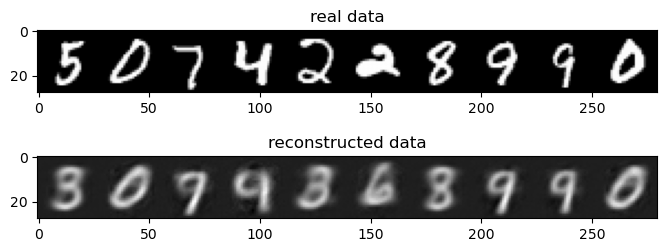

In [30]:
#optimizer = optim.SGD(ae.parameters(), lr=1e-4, momentum=0.9)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Prepare some plotting
sample = next(iter(test_loader))
X_test = sample[0][:10].view(-1, 28, 28)
upper  = X_test.detach().numpy().transpose(1, 0, 2).reshape(-1, 10*28)

fig, axs = plt.subplots(2, 1, figsize=(8,3))
fig.show()
axs[0].imshow(upper, cmap='gray')
axs[0].set_title('real data')

for epoch in range(1, 11):
    train(ae, train_loader, optimizer, epoch)

Now we can compress images into a two dimensional space, where we can actually plot their position against each other. Let's do that.

tensor([2, 5, 6, 2, 8, 1, 7, 8, 4, 2, 6, 9, 9, 2, 5, 0, 5, 4, 6, 2, 4, 4, 7, 2,
        4, 7, 3, 9, 7, 7, 8, 4, 8, 2, 6, 5, 7, 4, 6, 7, 0, 6, 6, 7, 7, 1, 0, 7,
        7, 6, 4, 3, 9, 7, 4, 1, 3, 9, 3, 7, 8, 1, 5, 3, 4, 1, 8, 9, 9, 6, 3, 9,
        0, 1, 8, 8, 3, 5, 7, 9, 5, 6, 7, 0, 2, 9, 8, 8, 4, 6, 5, 8, 1, 4, 4, 6,
        2, 7, 9, 4, 8, 4, 6, 5, 4, 6, 8, 2, 6, 3, 9, 4, 0, 1, 2, 1, 1, 6, 0, 7])


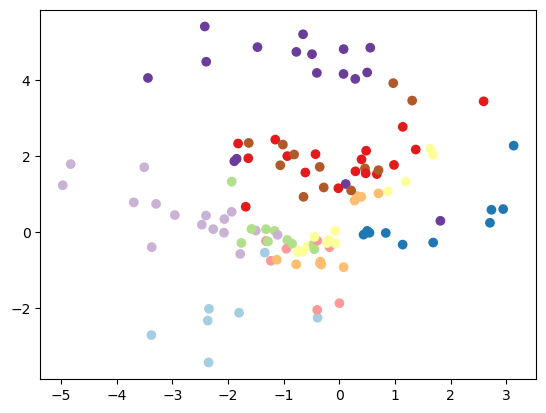

In [31]:
# This import registers the 3D projection, but is otherwise unused.
sample   = next(iter(train_loader))
X_train  = sample[0].view(-1, 28, 28)
embed    = ae.encode(X_train).detach().numpy()

print(sample[1])


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embed[:,0], embed[:,1], c=sample[1], cmap='Paired')

plt.savefig('Autoencoder.pdf')

This is okay but there is no clear relation between the classes and the embeddings. Okay, there are some tendencies, but it is not easy to generate new data. We could try though. 

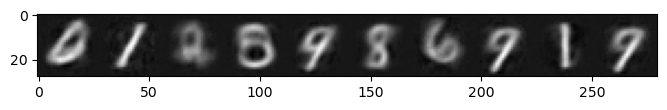

In [32]:
samples = np.zeros((10, 2))
for i in range(10):
    sel = sample[1] == i
    mu  = np.mean(embed[sel], axis=0)
    var = np.var(embed[sel], axis=0)
    samples[i] = np.random.multivariate_normal(mu, np.diag(var))

# samples = np.random.normal(mu, np.diag(std), (10, 3))
generated = ae.decode(torch.from_numpy(samples).float())

fig, ax = plt.subplots(figsize=(8,1.5))

img = generated.detach().numpy()
img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
#img = img * 0.3081 + 0.1307
ax.imshow(img, cmap='gray')


## Variational Auto-encoders


The motivation is now to find a way to make the embeddings more structured. Here, we refer to structure as a simple distribution, that can easily be sampled from.

Up til now, we have considered auto-encoders consisting of two components.

1. An encoder $P(z | x)$, that approximates some unknown prior distribution $P(z | X)$
2. A decoder $P(X | z)$, that approximately decodes the latent variables, $z$,  into the space of $X$.

The idea of VAE is to infer $P(z)$ using $P(z|X)$. I.e., we want to make our latent variable likely under our data.
We do this by modeling the true distribution $P(z|X)$ using a simpler distribution that is easy to evaluate, e.g. Gaussian, and minimize the difference between those two distribution using KL divergence.

**Your task**

The loss function is composed of two terms:
1. *Reconstruction term* on the final layer. 
    * This term helps making the encoding-decoding scheme as performant as possible. You could use mean-square error,
    
    $L_{recon} = \left \| x-\hat x \right \|_2^2$
    
1. *Regularisation term*  on the latent layer.
    * Regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution.
    * Expressed as the Kulback-Leibler divergence between the returned distribution and a standard Gaussian

### Using Neural Networks


C:\Users\frede\AppData\Local\Temp\ipykernel_5436\2406607476.py:80: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1: 188.70815224609376
2: 166.56136318359376
3: 162.47097985026042
4: 160.17786982421876
5: 158.63594837239583
6: 157.36915576171876
7: 156.4271383138021
8: 155.56163629557292
9: 154.8398851236979
10: 154.163502734375


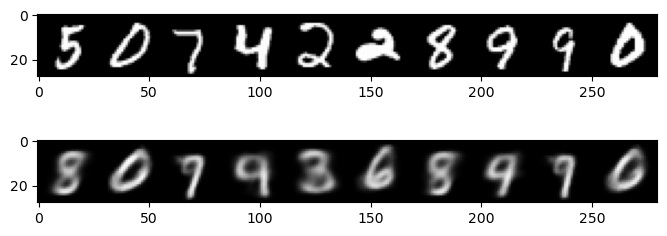

In [33]:
bottleneck_size = 2

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28**2, 400)
        self.fc21 = nn.Linear(400, bottleneck_size)
        self.fc22 = nn.Linear(400, bottleneck_size)
        self.fc3 = nn.Linear(bottleneck_size, 400)
        self.fc4 = nn.Linear(400, 28**2)

    def encode(self, x):
        x  = x.view(-1, 28**2)
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        log_sigma = self.fc22(h1)
        return mu, log_sigma

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, log_sigma = self.encode(x.view(-1, 28**2))
        z = self.reparameterize(mu, log_sigma)
        return self.decode(z), mu, log_sigma


vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


def loss_function(recon_x, x, mu, z_log_sigma):
    # Since the image is in the range [0:1] we can use Binary Cross Entropy as reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    
    # https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/
    # In practice, it’s better to model Σ(X) as logΣ(X), 
    # as it is more numerically stable to take exponent compared to computing log. 
    # Hence, our final KL divergence term is:
    
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    KLD = 0.5* torch.sum( z_log_sigma.exp() + mu.pow(2) - z_log_sigma   - 1)
    
    return BCE + KLD

def draw(model):
    img = model(X_test)[0].detach().numpy()
    img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307

    axs[1].imshow(img, cmap='gray')
    fig.canvas.draw()


def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, log_sigma = vae(data)
        
        if batch_idx % 100 == 0:
            draw(vae)

        loss = loss_function(recon_batch, data, mu, log_sigma)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"{epoch}: {train_loss / len(train_loader.dataset)}")


fig, axs = plt.subplots(2, 1, figsize=(8,3))
fig.show()
axs[0].imshow(upper, cmap='gray')
    
for epoch in range(1, 11):
    train(epoch)


**Questions**
1. The encoder outputs two variables: [mu, log_sigma]. What do you think they represent?

mean and "variance" of normal distributions around our something
1. What is the purpose of the reparameterization? You may find the answer in [Kristia's blog](https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/).

There is, however a trick called reparameterization trick, which makes the network differentiable. Reparameterization trick basically divert the non-differentiable operation out of the network, so that, even though we still involve a thing that is non-differentiable, at least it is out of the network, hence the network could still be trained.

We sample $\varepsilon \sim N(0,1)$ and then find our $z_i = \mu_i + \varepsilon_i \sigma_i$, which is distributed as $N(\mu_i, \sigma^2)$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


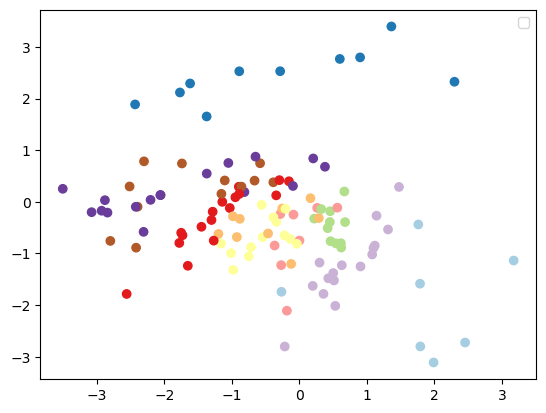

In [34]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

X_train  = sample[0].view(-1, 28, 28)
mu, log_sigma    = vae.encode(X_train)
mu = mu.detach().numpy()
# var = torch.exp(logvar)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(mu[:,0], mu[:,1], c=sample[1], cmap='Paired')
ax.legend()
print(sample[1].unique())

plt.savefig('VAE.pdf')

[[-2.00000000e+00  0.00000000e+00]
 [-1.80000000e+00 -5.00000000e-01]
 [-1.60000000e+00 -1.00000000e+00]
 [-1.40000000e+00 -1.50000000e+00]
 [-1.20000000e+00 -2.00000000e+00]
 [-1.00000000e+00 -2.50000000e+00]
 [-8.00000000e-01 -3.00000000e+00]
 [-6.00000000e-01 -3.50000000e+00]
 [-4.00000000e-01 -4.00000000e+00]
 [-2.00000000e-01 -4.50000000e+00]
 [-2.77555756e-16 -5.00000000e+00]]


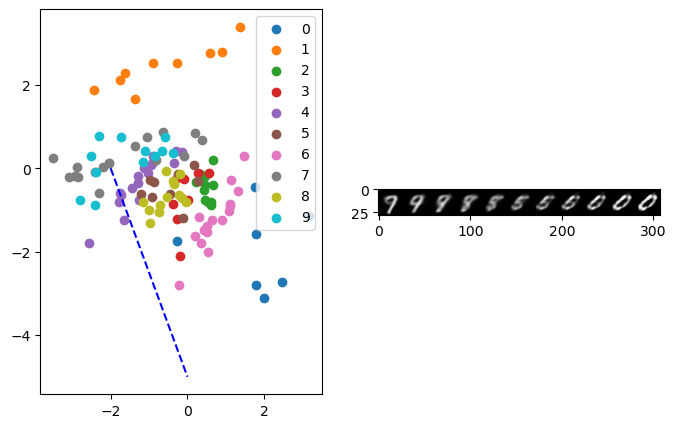

In [35]:
y = sample[1].numpy()
mean_0  = mu[y == 0]
mean_3  = mu[y == 3]
mean_0  = np.array([0, 5]) # mean_0.(axis=0)
mean_3  = np.array([0, 10]) # mean_0.mean(axis=0)
mean_0  = np.array([0, -5]) # mean_0.(axis=0)
mean_3  = np.array([-2, 0]) # mean_0.mean(axis=0)


diff    = (mean_0 - mean_3) / 10
Zs      = np.zeros((11, 2))
Zs[0]   = mean_3
for i in range(1, 11):
    Zs[i] = Zs[i-1] + diff

print(Zs)

# samples = np.random.normal(mu, np.diag(std), (10, 3))
generated = vae.decode(torch.from_numpy(Zs).float())

fig, ax = plt.subplots(1, 2, figsize=(8,5))

for i in range(10):
    sel = y == i
    ax[0].scatter(mu[sel,0], mu[sel,1], label=f"{i}")
ax[0].legend()
ax[0].plot(Zs[:,0], Zs[:,1], 'b--', label="Dir. of variation")

img = generated.detach().numpy()
img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 11*28)
#img = img * 0.3081 + 0.1307
ax[1].imshow(img, cmap='gray')

**Questions**

1. What do you think of this latent representation? In terms of quality? In terms of smoothness? Compare to the same plot for the traditional autoencoder.

Seems alright, similar digits appear close to each other and more distinct ones appears seperated
1. Which digits does the model faithfully reconstruct? Which digits does it have trouble reconstructing? Why?

1 and 0 are good, 8, 3, 2, 6 are not so good.
1. What happens if you set the weight of the KL term to, say 5 (KLD *= 5), and re-train the model?

Worse (idk why)
Encoding, decoding and latent space interpolation

your task is to:
1. Encode an image of a 7 and an image of a 9.
1. Decode the encodings (to generate reconstructed images)
1. Interpolate between the two digits in latent space. You can use the code above as inspiration



# References
[[1]](https://arxiv.org/pdf/1312.6114.pdf) Kingma, D.P. and Welling, M., 2013. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.  

[[2]](https://arxiv.org/pdf/1606.05908.pdf) Doersch, C., 2016. Tutorial on variational autoencoders. arXiv preprint arXiv:1606.05908.

[[3]](https://arxiv.org/pdf/1606.05579.pdf) Higgins, I., Matthey, L., Glorot, X., Pal, A., Uria, B., Blundell, C., Mohamed, S. and Lerchner, A., 2016. Early visual concept learning with unsupervised deep learning. arXiv preprint arXiv:1606.05579.

[[4]](https://github.com/fhvilshoj/variational-autoencoders/blob/master/VAEs.ipynb) Frederik Hvilshøj's github page